In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix

In [43]:
transform = transforms.ToTensor()

In [44]:
train_data = datasets.MNIST(root = '/home/maxime3343/Documents/Jupyter NoteBook/Image Datasets', train = True, download=True, transform=transform)

In [45]:
test_data = datasets.MNIST(root='/home/maxime3343/Documents/Jupyter NoteBook/Image Datasets',train = False, download = True, transform=transform)

In [46]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

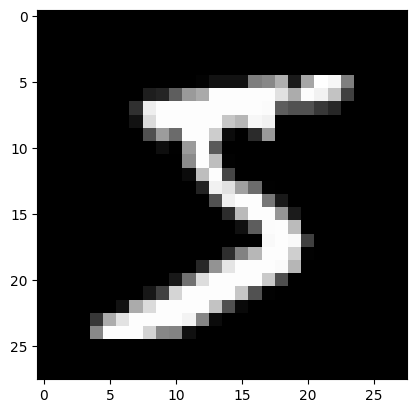

In [47]:
# Image sample from the Dataset.
image, label = train_data[0]
plt.imshow(image.reshape(28,28), cmap='gray')

In [48]:
# Convolutional Neural Network.

class Model(nn.Sequential):
    
    def __init__(self):
        super().__init__(
            # Outputs 6 filters out of the image.
            # Losing 2 pixel on width and height because of the kernel_size.
            nn.Conv2d(in_channels=1,out_channels=6, kernel_size=3, stride=1),
            
            # Activation Function.
            nn.ReLU(),
            
            # Pooling Layer.
            nn.MaxPool2d(2,2),
            
            # Another Conv Layer.
            # We still have 6 channels, but each image should be reduced by 2 (width and height) to 13x13.
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            
            # We have an input image of 11x11 which ends up to 5x5.
            nn.MaxPool2d(2,2),
            
            # We must flatten out the image before feeding it inside a Linear Layer.
            # Flattens out the Channels, Width and Height.
            nn.Flatten(),
            
            # Usual ANN layers.
            nn.Linear(400,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10),
            nn.LogSoftmax(dim=1)
        )

In [49]:
model = Model()

In [50]:
# Quick example of the Model with one image only.

# Changing dimension so it can be accepted within the network.
# Acts as a batch_number parameter since batches will be fed trough the model.
image = image.view(-1,1,28,28)
with torch.no_grad():
    out = model(image)
    print(f'Here is the unnormalized logits output of size 10 from the model: {out}')

Here is the unnormalized logits output of size 10 from the model: tensor([[-2.2333, -2.4068, -2.2162, -2.3375, -2.2852, -2.2721, -2.3770, -2.2131,
         -2.2958, -2.4145]])


In [51]:
learning_rate = 0.001
epochs = 5

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [53]:
# Training with MNIST Dataset.

import time
start_time = time.time()

#Trackers.
train_losses = []
test_losses = []

for i in range(epochs):
    
    # Enumerating over the batches of our train_loader.
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1 # Start batch count at 1.
        
        # Getting back LogSoftmax of size 10.
        y_pred = model(X_train)
        
        trn_loss = criterion(y_pred, y_train)
        
        # Performs Backpropagation.
        optimizer.zero_grad()
        trn_loss.backward()
        optimizer.step()
        
        # Prints out some results during the training.
        if b%2000 == 0:
            print(f'Epoch {i} batch:{b} loss:{trn_loss.item()}')
            
            # Test Dataset as we are training the data.
            with torch.no_grad():
                for b, (X_test, y_test) in enumerate(test_loader):
                    y_val = model(X_test)
                    tst_loss = criterion(y_val, y_test)
                    
            # We append to both Losses Lists.
            train_losses.append(trn_loss)
            test_losses.append(tst_loss)
    
# Prints out total duration of the training.
print(f'Total time taken by training: {time.time()-start_time} seconds')

Epoch 0 batch:2000 loss:0.12039627134799957
Epoch 0 batch:4000 loss:0.05691085383296013
Epoch 0 batch:6000 loss:0.009344806894659996
Epoch 1 batch:2000 loss:0.032861270010471344
Epoch 1 batch:4000 loss:0.00020014637266285717
Epoch 1 batch:6000 loss:0.13383068144321442
Epoch 2 batch:2000 loss:0.00236495747230947
Epoch 2 batch:4000 loss:0.00010813582775881514
Epoch 2 batch:6000 loss:0.1387176513671875
Epoch 3 batch:2000 loss:0.0010467885294929147
Epoch 3 batch:4000 loss:1.6331334336427972e-05
Epoch 3 batch:6000 loss:0.007938762195408344
Epoch 4 batch:2000 loss:0.003085253993049264
Epoch 4 batch:4000 loss:0.004215872846543789
Epoch 4 batch:6000 loss:1.879791307146661e-05
Total time taken by training: 91.47966051101685 seconds


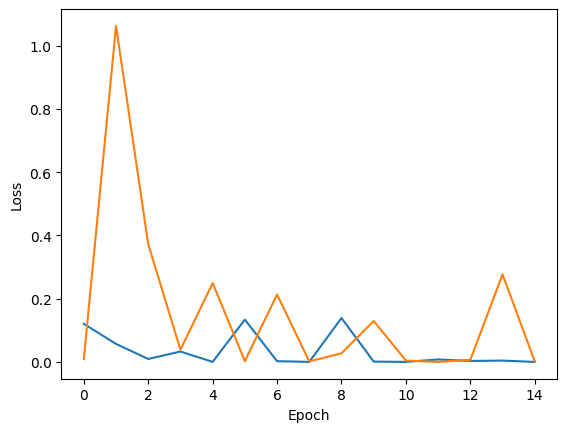

In [54]:
with torch.no_grad():
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

In [55]:
# Evaluation of the model.

# Tracker.
correct_number = 0

with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
        y_val = model(X_test)
        loss = criterion(y_val, y_test)
    
        prediction = torch.argmax(y_val, dim=1)
        correct_number += (prediction==y_test).sum()
        
print(f'{correct_number} numbers out of 10000 were guessed right by the Model. Gives out an accuracy of {(correct_number/10000) * 100}%')

9892 numbers out of 10000 were guessed right by the Model. Gives out an accuracy of 98.91999816894531%
